# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import clone_model
from keras.models import Sequential
from keras.layers import Dense, Activation, PReLU
from keras.optimizers import SGD , Adam, RMSprop
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

## Ignore the warnings below

2025-10-19 02:30:53.073957: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-19 02:30:53.074990: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-19 02:30:53.140970: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-19 02:30:53.206210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760841053.320344     298 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760841053.34

The following code block contains an 8x8 matrix that will be used as a maze object:

In [3]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [4]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [5]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
patience = 10

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


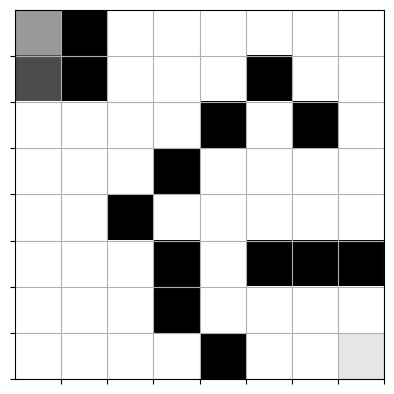

In [6]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [7]:
def play_game(model, qmaze, pirate_cell, max_steps=None):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    steps = 0
    if max_steps is None:
        max_steps = qmaze.maze.size * 4  # safety cutoff

    while steps < max_steps:
        state = np.asarray(envstate, dtype=np.float32)
        if state.ndim == 1:
            state = np.expand_dims(state, axis=0)

        q_values = model(state, training=False).numpy()
        action = np.argmax(q_values[0])

        envstate, reward, game_status = qmaze.act(action)
        steps += 1

        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

    return False  # timed out with no result

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [8]:
def completion_check(model, maze_or_qmaze, max_steps=None):
    # Accept either raw numpy maze or TreasureMaze instance
    if isinstance(maze_or_qmaze, TreasureMaze):
        qmaze = maze_or_qmaze
    else:
        qmaze = TreasureMaze(maze_or_qmaze)

    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            continue
        if not play_game(model, qmaze, cell, max_steps=max_steps):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [9]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

In [10]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        q_values = model(x, training=True)
        loss = loss_fn(y, q_values)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

E0000 00:00:1760841061.636829     298 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1760841061.641266     298 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [14]:
def qtrain(model, maze, **opt):
    # exploration factor
    global epsilon 
    
    # Number of epochs
    n_epoch = opt.get('n_epoch', 15000)
    
    # Maximum meory to store episodes
    max_memory = opt.get('max_memory', 1000)
    
    # Maximum data size for training
    data_size = opt.get('data_size', 50)
    
    # Frequency of target network updates
    target_update_freq = opt.get('target_update_freq', 50)
    
    # Start time
    start_time = datetime.datetime.now()
    
    # Construct environment/game from numpy array: maze (see argument above)
    qmaze = TreasureMaze(maze)
    
    # Target Network to better guide training
    target_model = clone_model(model)
    target_model.set_weights(model.get_weights())
    
    # Initialize experience replay object
    experience = GameExperience(model, target_model, max_memory)

    win_history = [] # history of win/lose game
    hsize = qmaze.maze.size // 2 #history window size
    win_rate = 0.0
    
    # START_HERE
    for epoch in range(n_epoch):
        loss = 0.0
        n_episodes = 0

        # Reset environment at a random starting cell
        agent_cell = random.choice(qmaze.free_cells)
        qmaze.reset(agent_cell)

        # Set initial environment state
        env_state = qmaze.observe()


        game_over = False

        while not game_over:
            previous_envstate = env_state

            # --- Action selection (Exploration vs Exploitation) ---
            if np.random.rand() < epsilon:
                # Exploration: choose random valid action
                valid_actions = qmaze.valid_actions()
                action = random.choice(valid_actions)
            else:
                # Exploitation: choose best action from the model
                q_values = experience.predict(previous_envstate)
                action = np.argmax(q_values)
            # --- Take action and observe results ---
            env_state, reward, game_status = qmaze.act(action)
            game_over = (game_status != 'not_over')

            # --- Record win/loss ---
            if game_status == 'win':
                win_history.append(1)
            elif game_status == 'lose':
                win_history.append(0)

            # --- Store episode in replay memory ---
            episode = [previous_envstate, action, reward, env_state, game_status]
            experience.remember(episode)

            # --- Train the neural network using replay data ---
            inputs, targets = experience.get_data(data_size)
            if inputs is not None:
                batch_loss = model.train_on_batch(inputs, targets)
                loss += batch_loss

            n_episodes += 1

        # --- Update the target network periodically ---
        if epoch % target_update_freq == 0:
            target_model.set_weights(model.get_weights())

        # --- Compute win rate over recent history ---
        hsize = qmaze.maze.size // 2
        win_rate = sum(win_history[-hsize:]) / hsize if len(win_history) >= hsize else 0.0

        # Print the epoch, loss, episode, win count, win rate, and time for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        print("Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}".format(
            epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))

        # Check if training has exhausted all free cells and if in all
        # cases the agent won
        if win_rate > 0.9:
            epsilon = 0.05
        else:
            epsilon = max(epsilon * epsilon_decay, epsilon_min)
    
        if win_rate >= 0.999 and completion_check(model, maze):
            print(f"Reached 100% win rate at epoch {epoch}")
            break

    total_time = format_time((datetime.datetime.now() - start_time).total_seconds())
    print("Training complete in:", total_time)


# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

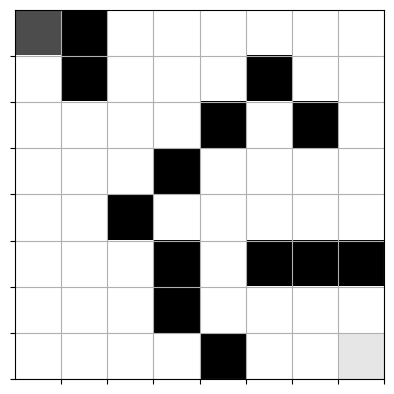

In [15]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [16]:
model = build_model(maze)
qtrain(model, maze, n_epoch=1000, max_memory=8*maze.size, data_size=32, target_update_freq=50)

Epoch: 000/999 | Loss: 11.7228 | Episodes: 154 | Win count: 0 | Win rate: 0.000 | time: 4.5 seconds
Epoch: 001/999 | Loss: 0.4263 | Episodes: 18 | Win count: 1 | Win rate: 0.000 | time: 4.9 seconds
Epoch: 002/999 | Loss: 2.6490 | Episodes: 154 | Win count: 1 | Win rate: 0.000 | time: 7.7 seconds
Epoch: 003/999 | Loss: 1.6337 | Episodes: 139 | Win count: 1 | Win rate: 0.000 | time: 10.4 seconds
Epoch: 004/999 | Loss: 1.3632 | Episodes: 148 | Win count: 1 | Win rate: 0.000 | time: 13.2 seconds
Epoch: 005/999 | Loss: 0.5812 | Episodes: 73 | Win count: 2 | Win rate: 0.000 | time: 14.6 seconds
Epoch: 006/999 | Loss: 1.0573 | Episodes: 149 | Win count: 2 | Win rate: 0.000 | time: 17.5 seconds
Epoch: 007/999 | Loss: 0.9729 | Episodes: 155 | Win count: 2 | Win rate: 0.000 | time: 20.3 seconds
Epoch: 008/999 | Loss: 0.8659 | Episodes: 152 | Win count: 2 | Win rate: 0.000 | time: 23.0 seconds
Epoch: 009/999 | Loss: 0.4647 | Episodes: 87 | Win count: 3 | Win rate: 0.000 | time: 24.6 seconds
Epoch

Epoch: 082/999 | Loss: 0.3550 | Episodes: 144 | Win count: 29 | Win rate: 0.531 | time: 194.4 seconds
Epoch: 083/999 | Loss: 0.3416 | Episodes: 139 | Win count: 29 | Win rate: 0.531 | time: 197.3 seconds
Epoch: 084/999 | Loss: 0.1910 | Episodes: 78 | Win count: 30 | Win rate: 0.562 | time: 198.9 seconds
Epoch: 085/999 | Loss: 0.1490 | Episodes: 61 | Win count: 31 | Win rate: 0.562 | time: 200.1 seconds
Epoch: 086/999 | Loss: 0.3408 | Episodes: 140 | Win count: 31 | Win rate: 0.562 | time: 203.1 seconds
Epoch: 087/999 | Loss: 0.0024 | Episodes: 1 | Win count: 32 | Win rate: 0.594 | time: 203.2 seconds
Epoch: 088/999 | Loss: 0.0024 | Episodes: 1 | Win count: 33 | Win rate: 0.594 | time: 203.2 seconds
Epoch: 089/999 | Loss: 0.3364 | Episodes: 139 | Win count: 33 | Win rate: 0.562 | time: 206.0 seconds
Epoch: 090/999 | Loss: 0.0964 | Episodes: 40 | Win count: 34 | Win rate: 0.562 | time: 206.8 seconds
Epoch: 091/999 | Loss: 0.1203 | Episodes: 50 | Win count: 35 | Win rate: 0.562 | time: 20

Epoch: 163/999 | Loss: 0.0941 | Episodes: 43 | Win count: 94 | Win rate: 0.906 | time: 328.8 seconds
Epoch: 164/999 | Loss: 0.0525 | Episodes: 24 | Win count: 95 | Win rate: 0.906 | time: 329.3 seconds
Epoch: 165/999 | Loss: 0.1050 | Episodes: 48 | Win count: 96 | Win rate: 0.938 | time: 330.5 seconds
Epoch: 166/999 | Loss: 0.0109 | Episodes: 5 | Win count: 97 | Win rate: 0.938 | time: 330.7 seconds
Epoch: 167/999 | Loss: 0.0044 | Episodes: 2 | Win count: 98 | Win rate: 0.938 | time: 330.7 seconds
Epoch: 168/999 | Loss: 0.0984 | Episodes: 45 | Win count: 99 | Win rate: 0.938 | time: 331.9 seconds
Epoch: 169/999 | Loss: 0.0437 | Episodes: 20 | Win count: 100 | Win rate: 0.938 | time: 332.4 seconds
Epoch: 170/999 | Loss: 0.1595 | Episodes: 73 | Win count: 101 | Win rate: 0.938 | time: 334.2 seconds
Epoch: 171/999 | Loss: 0.0284 | Episodes: 13 | Win count: 102 | Win rate: 0.938 | time: 334.5 seconds
Epoch: 172/999 | Loss: 0.2922 | Episodes: 134 | Win count: 102 | Win rate: 0.906 | time: 3

Epoch: 244/999 | Loss: 0.0257 | Episodes: 13 | Win count: 171 | Win rate: 0.938 | time: 6.87 minutes
Epoch: 245/999 | Loss: 0.0276 | Episodes: 14 | Win count: 172 | Win rate: 0.969 | time: 6.88 minutes
Epoch: 246/999 | Loss: 0.0611 | Episodes: 31 | Win count: 173 | Win rate: 0.969 | time: 6.89 minutes
Epoch: 247/999 | Loss: 0.0649 | Episodes: 33 | Win count: 174 | Win rate: 0.969 | time: 6.90 minutes
Epoch: 248/999 | Loss: 0.0570 | Episodes: 29 | Win count: 175 | Win rate: 0.969 | time: 6.91 minutes
Epoch: 249/999 | Loss: 0.0530 | Episodes: 27 | Win count: 176 | Win rate: 0.969 | time: 6.93 minutes
Epoch: 250/999 | Loss: 0.0608 | Episodes: 31 | Win count: 177 | Win rate: 0.969 | time: 6.94 minutes
Epoch: 251/999 | Loss: 0.0020 | Episodes: 1 | Win count: 178 | Win rate: 0.969 | time: 6.94 minutes
Epoch: 252/999 | Loss: 0.0607 | Episodes: 31 | Win count: 179 | Win rate: 1.000 | time: 6.95 minutes
Epoch: 253/999 | Loss: 0.0137 | Episodes: 7 | Win count: 180 | Win rate: 1.000 | time: 6.97 

Epoch: 326/999 | Loss: 0.0261 | Episodes: 14 | Win count: 253 | Win rate: 1.000 | time: 9.71 minutes
Epoch: 327/999 | Loss: 0.0168 | Episodes: 9 | Win count: 254 | Win rate: 1.000 | time: 9.77 minutes
Epoch: 328/999 | Loss: 0.0130 | Episodes: 7 | Win count: 255 | Win rate: 1.000 | time: 9.83 minutes
Epoch: 329/999 | Loss: 0.0540 | Episodes: 29 | Win count: 256 | Win rate: 1.000 | time: 9.86 minutes
Epoch: 330/999 | Loss: 0.0074 | Episodes: 4 | Win count: 257 | Win rate: 1.000 | time: 9.88 minutes
Epoch: 331/999 | Loss: 0.0372 | Episodes: 20 | Win count: 258 | Win rate: 1.000 | time: 9.91 minutes
Epoch: 332/999 | Loss: 0.0446 | Episodes: 24 | Win count: 259 | Win rate: 1.000 | time: 9.94 minutes
Epoch: 333/999 | Loss: 0.0408 | Episodes: 22 | Win count: 260 | Win rate: 1.000 | time: 9.97 minutes
Epoch: 334/999 | Loss: 0.0037 | Episodes: 2 | Win count: 261 | Win rate: 1.000 | time: 10.03 minutes
Epoch: 335/999 | Loss: 0.0519 | Episodes: 28 | Win count: 262 | Win rate: 1.000 | time: 10.13 

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

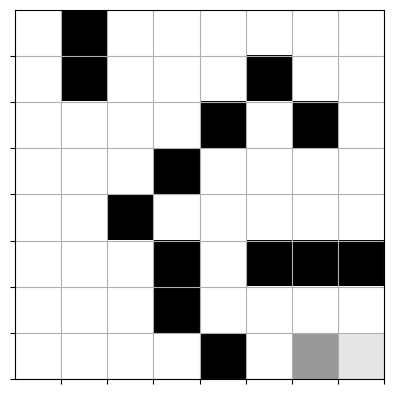

In [17]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

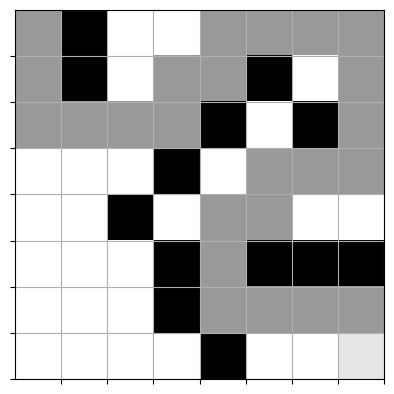

In [18]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work.
Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.html). Download this file as an .html file clicking on ***file*** in *Jupyter Notebook*, navigating down to ***Download as*** and clicking on ***.html***. 
Download a copy of your .html file and submit it to Brightspace.